# Multimodal Stance Classification: Training + Error Analysis

- Model: DeBERTa + Vision Encoder (Multimodal)


In [1]:
# Here we can choose our model (Vision Encoder, Fusion Type, if we use captions, and which captions)
VISION_ENCODER = "align"          # "align","blip"
FUSION_TYPE    = "proj_concat"    # "proj_concat","mean", "concat", "weighted_mean", "gated"
USE_CAPTION    = True             # True | False
CAPTION_TYPE   = "caption_blip2" # "caption_blip2", "caption_git"  ( USE_CAPTION=True)

#Reproducibility 
SEED = 1024


DATA_PATH  = "../../../data/"
IMG_PATH   = "../../../data/images"
OUTPUT_DIR = "../../../results/multimodal/error_analysis/"

# Same Hyperparameters as always (We can change them for further analysis)
MAX_TEXT_LENGTH = 128
COMMON_DIM      = 768
NUM_CLASSES     = 2
BATCH_SIZE      = 16
NUM_EPOCHS      = 15
LEARNING_RATE   = 2e-5
WEIGHT_DECAY    = 1e-4
WARMUP_RATIO    = 0.1
PATIENCE        = 5
DROPOUT         = 0.1

In [12]:
#Libraries
import os
import re
import copy
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from PIL import Image
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

from transformers import AutoTokenizer, AutoModel, BlipProcessor, BlipModel, AlignProcessor, AlignModel, get_linear_schedule_with_warmup
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report

os.makedirs(OUTPUT_DIR, exist_ok=True)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Models
TEXT_MODEL_NAME  = "microsoft/deberta-v3-base"
BLIP_MODEL_NAME  = "Salesforce/blip-itm-base-coco"
ALIGN_MODEL_NAME = "kakaobrain/align-base"
VISION_MODEL_NAME = ALIGN_MODEL_NAME if VISION_ENCODER == "align" else BLIP_MODEL_NAME


caption_desc = f"+ {CAPTION_TYPE}" if USE_CAPTION else "(no caption)"
MODEL_DESC   = f"DeBERTa + {VISION_ENCODER.upper()} {caption_desc} | Fusion: {FUSION_TYPE}"
seed_desc    = str(SEED) if SEED is not None else "random"
ckpt_name  = f"model_{VISION_ENCODER}_{FUSION_TYPE}"
ckpt_name += f"_{CAPTION_TYPE}" if USE_CAPTION else "_nocaption"
ckpt_name += f"_seed{SEED}" if SEED is not None else "_seedrandom"
CKPT_PATH  = os.path.join(OUTPUT_DIR, f"{ckpt_name}.pt")
PRED_PATH  = os.path.join(OUTPUT_DIR, f"{ckpt_name}_test_predictions.csv")

print(f"  Model:       {MODEL_DESC}")
print(f"  Seed:        {seed_desc}")
print(f"  Predictions: {PRED_PATH}")

  Model:       DeBERTa + ALIGN + caption_blip2 | Fusion: proj_concat
  Seed:        1024
  Predictions: ../../../results/multimodal/error_analysis/model_align_proj_concat_caption_blip2_seed1024_test_predictions.csv


In [3]:
def set_seed(seed):
    """Set all random seeds. Call with seed=None to skip."""
    if seed is None:
        print("No seed set. training will be non-deterministic.")
        return
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark     = False
    os.environ['PYTHONHASHSEED']       = str(seed)
    print(f"Seed set to {seed}")

set_seed(SEED)

Seed set to 1024


In [4]:
stance_2id = {"oppose": 0, "support": 1}
id_2stance = {0: "oppose", 1: "support"}

df_train = pd.read_csv(os.path.join(DATA_PATH, "train_with_captions.csv"))
df_dev   = pd.read_csv(os.path.join(DATA_PATH, "dev_with_captions.csv"))
df_test  = pd.read_csv(os.path.join(DATA_PATH, "test_with_captions.csv"))

for df in [df_train, df_dev, df_test]:
    df["label"] = df["stance"].map(stance_2id)

print(f"Train: {len(df_train)} | Dev: {len(df_dev)} | Test: {len(df_test)}")
print(f"\nTrain: {df_train['stance'].value_counts().to_dict()}")
print(f"Dev:   {df_dev['stance'].value_counts().to_dict()}")
print(f"Test:  {df_test['stance'].value_counts().to_dict()}")

Train: 2190 | Dev: 200 | Test: 300

Train: {'support': 1095, 'oppose': 1095}
Dev:   {'oppose': 127, 'support': 73}
Test:  {'oppose': 182, 'support': 118}


### Dataset Class

In [5]:
class MultimodalDataset(Dataset):
    """
    Dynamic dataset. Text input adapts based on USE_CAPTION.
    - USE_CAPTION=False: input = tweet_text
    - USE_CAPTION=True:  input = tweet_text [SEP] caption
    """
    def __init__(self, df, img_dir, tokenizer, image_processor,
                 use_caption, caption_col, max_length):
        self.df              = df.reset_index(drop=True)
        self.img_dir         = img_dir
        self.tokenizer       = tokenizer
        self.image_processor = image_processor
        self.use_caption     = use_caption
        self.caption_col     = caption_col
        self.max_length      = max_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row  = self.df.iloc[idx]
        text = str(row['tweet_text'])

        if self.use_caption:
            caption = str(row[self.caption_col])
            text    = f"{text} [SEP] {caption}"

        text_enc = self.tokenizer(
            text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        img_path = os.path.join(self.img_dir, str(row['tweet_id']) + ".jpg")
        try:
            image = Image.open(img_path).convert('RGB')
        except:
            image = Image.new("RGB", (224, 224), color=(128, 128, 128))

        img_enc = self.image_processor(images=image, return_tensors='pt')

        return {
            'input_ids':      text_enc['input_ids'].squeeze(0),
            'attention_mask': text_enc['attention_mask'].squeeze(0),
            'pixel_values':   img_enc['pixel_values'].squeeze(0),
            'label':          torch.tensor(row['label'], dtype=torch.long),
            'idx':            torch.tensor(idx, dtype=torch.long)
        }


def collate_fn(batch):
    return {
        'input_ids':      torch.stack([b['input_ids']      for b in batch]),
        'attention_mask': torch.stack([b['attention_mask'] for b in batch]),
        'pixel_values':   torch.stack([b['pixel_values']   for b in batch]),
        'labels':         torch.stack([b['label']          for b in batch]),
        'indices':        torch.stack([b['idx']            for b in batch])
    }

### Model Architecture

In [6]:
class MultimodalModel(nn.Module):
    """
    DeBERTa (text encoder) + BLIP or ALIGN (vision encoder).
    Fusion strategy configured via fusion_type parameter.
    """
    def __init__(self, text_model_name, vision_model_name, vision_type,
                 num_classes=2, fusion_type="proj_concat",
                 common_dim=768, dropout=0.1):
        
        super().__init__()
        self.fusion_type = fusion_type
        self.common_dim  = common_dim

        # --- Text encoder ---
        self.text_encoder = AutoModel.from_pretrained(text_model_name)
        self.text_dim     = self.text_encoder.config.hidden_size

        # --- Vision encoder ---
        if vision_type == "blip":
            blip_full           = BlipModel.from_pretrained(vision_model_name)
            self.vision_encoder = blip_full.vision_model
            self.vision_dim     = blip_full.config.vision_config.hidden_size
        else:  # align
            align_full          = AlignModel.from_pretrained(vision_model_name)
            self.vision_encoder = align_full.vision_model
            self.vision_dim     = align_full.config.vision_config.hidden_dim

        # --- Projections to common_dim ---
        self.text_projection   = nn.Linear(self.text_dim, common_dim)   if self.text_dim   != common_dim else nn.Identity()
        self.vision_projection = nn.Linear(self.vision_dim, common_dim) if self.vision_dim != common_dim else nn.Identity()

        # --- Fusion layers ---
        if fusion_type == "concat":
            self.fusion_layer = nn.Sequential(
                nn.Linear(common_dim * 2, common_dim), nn.ReLU(), nn.Dropout(dropout))

        elif fusion_type == "mean":
            self.fusion_layer = nn.Identity()

        elif fusion_type == "weighted_mean":
            self.text_weight   = nn.Parameter(torch.tensor(0.5))
            self.vision_weight = nn.Parameter(torch.tensor(0.5))
            self.fusion_layer  = nn.Identity()

        elif fusion_type == "proj_concat":
            proj_dim = common_dim // 2
            self.text_proj    = nn.Linear(common_dim, proj_dim)
            self.vision_proj  = nn.Linear(common_dim, proj_dim)
            self.fusion_layer = nn.Sequential(
                nn.Linear(proj_dim * 2, common_dim), nn.ReLU(), nn.Dropout(dropout))

        elif fusion_type == "gated":
            self.gate = nn.Sequential(
                nn.Linear(common_dim * 2, common_dim), nn.Sigmoid())
            self.fusion_layer = nn.Identity()

        else:
            raise ValueError(f"Unknown fusion_type: {fusion_type}")

        # --- Classifier ---
        self.classifier = nn.Sequential(
            nn.Linear(common_dim, common_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(common_dim // 2, num_classes)
        )

    def forward(self, input_ids, attention_mask, pixel_values):
        # Encode text
        text_emb = self.text_projection(
            self.text_encoder(
                input_ids=input_ids,
                attention_mask=attention_mask
            ).last_hidden_state[:, 0, :])

        # Encode image
        vision_emb = self.vision_projection(
            self.vision_encoder(pixel_values=pixel_values).pooler_output)

        # Fuse
        if self.fusion_type == "concat":
            fused = self.fusion_layer(torch.cat([text_emb, vision_emb], dim=1))
        elif self.fusion_type == "mean":
            fused = (text_emb + vision_emb) / 2
        elif self.fusion_type == "weighted_mean":
            w_t   = torch.sigmoid(self.text_weight)
            w_v   = torch.sigmoid(self.vision_weight)
            fused = (w_t * text_emb + w_v * vision_emb) / (w_t + w_v)
        elif self.fusion_type == "proj_concat":
            fused = self.fusion_layer(
                torch.cat([self.text_proj(text_emb), self.vision_proj(vision_emb)], dim=1))
        elif self.fusion_type == "gated":
            gate  = self.gate(torch.cat([text_emb, vision_emb], dim=1))
            fused = gate * text_emb + (1 - gate) * vision_emb

        return self.classifier(fused)

## Training

In [7]:
# Load tokenizer and vision processor
tokenizer = AutoTokenizer.from_pretrained(TEXT_MODEL_NAME)

if VISION_ENCODER == "align":
    vision_processor = AlignProcessor.from_pretrained(VISION_MODEL_NAME)
else:
    vision_processor = BlipProcessor.from_pretrained(VISION_MODEL_NAME)

print(f"Tokenizer: {TEXT_MODEL_NAME}")
print(f"Vision processor: {VISION_MODEL_NAME}")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Tokenizer: microsoft/deberta-v3-base
Vision processor: kakaobrain/align-base


In [8]:
# Build datasets and loaders
ds_kwargs = dict(
    img_dir         = IMG_PATH,
    tokenizer       = tokenizer,
    image_processor = vision_processor,
    use_caption     = USE_CAPTION,
    caption_col     = CAPTION_TYPE,
    max_length      = MAX_TEXT_LENGTH
)

train_ds = MultimodalDataset(df_train, **ds_kwargs)
dev_ds   = MultimodalDataset(df_dev,   **ds_kwargs)
test_ds  = MultimodalDataset(df_test,  **ds_kwargs)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  collate_fn=collate_fn)
dev_loader   = DataLoader(dev_ds,   batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

print(f"Train batches: {len(train_loader)} | Dev batches: {len(dev_loader)} | Test batches: {len(test_loader)}")

Train batches: 137 | Dev batches: 13 | Test batches: 19


In [9]:
# Initialize model
set_seed(SEED)

model = MultimodalModel(
    text_model_name   = TEXT_MODEL_NAME,
    vision_model_name = VISION_MODEL_NAME,
    vision_type       = VISION_ENCODER,
    num_classes       = NUM_CLASSES,
    fusion_type       = FUSION_TYPE,
    common_dim        = COMMON_DIM,
    dropout           = DROPOUT
).to(DEVICE)

total_params     = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nModel: {MODEL_DESC}")
print(f"Total parameters:     {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Seed set to 1024

Model: DeBERTa + ALIGN + caption_blip2 | Fusion: proj_concat
Total parameters:     247,944,530
Trainable parameters: 247,944,530


In [13]:
# Training loop
optimizer    = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
total_steps  = len(train_loader) * NUM_EPOCHS
warmup_steps = int(total_steps * WARMUP_RATIO)
scheduler    = get_linear_schedule_with_warmup(optimizer, warmup_steps, total_steps)
criterion    = nn.CrossEntropyLoss()

best_dev_f1      = 0.0
patience_counter = 0
best_state       = None
history          = []

print(f"\nTraining: {MODEL_DESC}")
print(f"Epochs: {NUM_EPOCHS} | LR: {LEARNING_RATE} | Batch: {BATCH_SIZE} | Patience: {PATIENCE}")
print(f"Total steps: {total_steps} | Warmup steps: {warmup_steps}\n")

for epoch in range(NUM_EPOCHS):

    # --- Train ---
    model.train()
    train_loss = 0.0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1:02d}/{NUM_EPOCHS}", leave=False):
        optimizer.zero_grad()
        logits = model(
            batch['input_ids'].to(DEVICE),
            batch['attention_mask'].to(DEVICE),
            batch['pixel_values'].to(DEVICE)
        )
        loss = criterion(logits, batch['labels'].to(DEVICE))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        train_loss += loss.item()

    # --- Validate ---
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in dev_loader:
            logits = model(
                batch['input_ids'].to(DEVICE),
                batch['attention_mask'].to(DEVICE),
                batch['pixel_values'].to(DEVICE)
            )
            all_preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
            all_labels.extend(batch['labels'].numpy())

    avg_loss = train_loss / len(train_loader)
    _, _, dev_f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='binary', pos_label=1, zero_division=0)
    dev_acc = accuracy_score(all_labels, all_preds)

    history.append({'epoch': epoch+1, 'train_loss': avg_loss, 'dev_f1': dev_f1, 'dev_acc': dev_acc})

    print(f"Epoch {epoch+1:02d} | Loss: {avg_loss:.4f} | Dev F1: {dev_f1:.4f} | Dev Acc: {dev_acc:.4f}", end="")

    if dev_f1 > best_dev_f1:
        best_dev_f1  = dev_f1
        patience_counter = 0
        best_state   = copy.deepcopy(model.state_dict())
        torch.save(best_state, CKPT_PATH)
        print("   Best")
    else:
        patience_counter += 1
        print(f" (patience {patience_counter}/{PATIENCE})")
        if patience_counter >= PATIENCE:
            print(f"Early stopping at epoch {epoch+1}.")
            break

model.load_state_dict(best_state)
print(f"\n  Training complete. Best Dev F1: {best_dev_f1:.4f}")
print(f"  Checkpoint saved: {CKPT_PATH}")


Training: DeBERTa + ALIGN + caption_blip2 | Fusion: proj_concat
Epochs: 15 | LR: 2e-05 | Batch: 16 | Patience: 5
Total steps: 2055 | Warmup steps: 205



Epoch 01/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 01 | Loss: 0.2843 | Dev F1: 0.8047 | Dev Acc: 0.8350   Best


Epoch 02/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 02 | Loss: 0.2453 | Dev F1: 0.8263 | Dev Acc: 0.8550   Best


Epoch 03/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 03 | Loss: 0.1688 | Dev F1: 0.8593 | Dev Acc: 0.9050   Best


Epoch 04/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 04 | Loss: 0.0975 | Dev F1: 0.8714 | Dev Acc: 0.9100   Best


Epoch 05/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 05 | Loss: 0.0309 | Dev F1: 0.8421 | Dev Acc: 0.8950 (patience 1/5)


Epoch 06/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 06 | Loss: 0.0255 | Dev F1: 0.8919 | Dev Acc: 0.9200   Best


Epoch 07/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 07 | Loss: 0.0109 | Dev F1: 0.8652 | Dev Acc: 0.9050 (patience 1/5)


Epoch 08/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 08 | Loss: 0.0080 | Dev F1: 0.8244 | Dev Acc: 0.8850 (patience 2/5)


Epoch 09/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 09 | Loss: 0.0075 | Dev F1: 0.8767 | Dev Acc: 0.9100 (patience 3/5)


Epoch 10/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 10 | Loss: 0.0033 | Dev F1: 0.8613 | Dev Acc: 0.9050 (patience 4/5)


Epoch 11/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 11 | Loss: 0.0001 | Dev F1: 0.8633 | Dev Acc: 0.9050 (patience 5/5)
Early stopping at epoch 11.

  Training complete. Best Dev F1: 0.8919
  Checkpoint saved: ../../../results/multimodal/error_analysis/model_align_proj_concat_caption_blip2_seed1024.pt


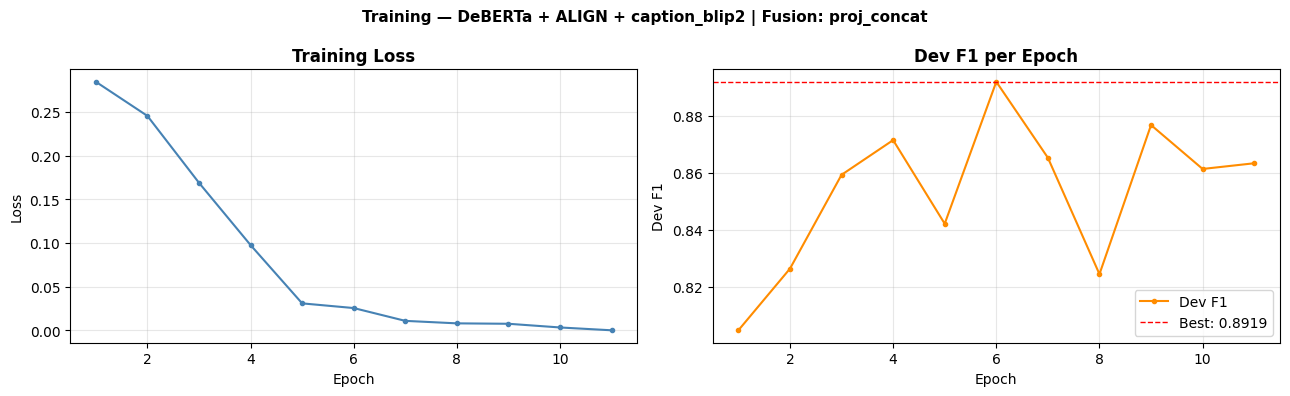

In [14]:
# Training curve
history_df = pd.DataFrame(history)
fig, axes  = plt.subplots(1, 2, figsize=(13, 4))

axes[0].plot(history_df['epoch'], history_df['train_loss'], marker='o', markersize=3, color='steelblue')
axes[0].set_xlabel('Epoch'); axes[0].set_ylabel('Loss')
axes[0].set_title('Training Loss', fontweight='bold'); axes[0].grid(alpha=0.3)

axes[1].plot(history_df['epoch'], history_df['dev_f1'], marker='o', markersize=3, color='darkorange', label='Dev F1')
axes[1].axhline(best_dev_f1, color='red', linestyle='--', linewidth=1, label=f'Best: {best_dev_f1:.4f}')
axes[1].set_xlabel('Epoch'); axes[1].set_ylabel('Dev F1')
axes[1].set_title('Dev F1 per Epoch', fontweight='bold')
axes[1].legend(); axes[1].grid(alpha=0.3)

plt.suptitle(f'Training — {MODEL_DESC}', fontsize=11, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, f'{ckpt_name}_training_curve.png'), dpi=150)
plt.show()

## Test Evaluation

In [15]:
# Run inference on test set
model.eval()
all_preds, all_probs, all_labels, all_indices = [], [], [], []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Test inference"):
        logits = model(
            batch['input_ids'].to(DEVICE),
            batch['attention_mask'].to(DEVICE),
            batch['pixel_values'].to(DEVICE)
        )
        probs = F.softmax(logits, dim=1)
        preds = torch.argmax(logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())
        all_labels.extend(batch['labels'].numpy())
        all_indices.extend(batch['indices'].numpy())

# Build predictions DataFrame
df_pred = df_test.copy()
df_pred['pred_label']   = all_preds
df_pred['prob_oppose']  = [p[0] for p in all_probs]
df_pred['prob_support'] = [p[1] for p in all_probs]
df_pred['confidence']   = df_pred.apply(
    lambda r: r['prob_support'] if r['pred_label'] == 1 else r['prob_oppose'], axis=1)
df_pred['pred_stance']  = df_pred['pred_label'].map(id_2stance)
df_pred['correct']      = (df_pred['pred_label'] == df_pred['label']).astype(int)
df_pred['error_type']   = 'correct'
df_pred.loc[(df_pred['label']==0) & (df_pred['pred_label']==1), 'error_type'] = 'FP'
df_pred.loc[(df_pred['label']==1) & (df_pred['pred_label']==0), 'error_type'] = 'FN'
df_pred['text_length']    = df_pred['tweet_text'].str.split().str.len()
df_pred['caption_length'] = df_pred[CAPTION_TYPE].str.split().str.len() if USE_CAPTION else 0
df_pred['uncertainty']    = np.abs(df_pred['prob_support'] - 0.5)

# Save
df_pred.to_csv(PRED_PATH, index=False)

# Subsets
df_fp      = df_pred[df_pred['error_type']=='FP'].reset_index(drop=True)
df_fn      = df_pred[df_pred['error_type']=='FN'].reset_index(drop=True)
df_correct = df_pred[df_pred['error_type']=='correct'].reset_index(drop=True)

# Metrics
test_acc  = accuracy_score(df_pred['label'], df_pred['pred_label'])
test_prec, test_rec, test_f1, _ = precision_recall_fscore_support(
    df_pred['label'], df_pred['pred_label'], average='binary', pos_label=1, zero_division=0)
cm = confusion_matrix(df_pred['label'], df_pred['pred_label'])

print("\n" + "="*65)
print(f"TEST RESULTS — {MODEL_DESC}")
print("="*65)
print(f"  F1 (binary, pos=1): {test_f1:.4f}")
print(f"  Accuracy:           {test_acc:.4f}")
print(f"  Precision:          {test_prec:.4f}")
print(f"  Recall:             {test_rec:.4f}")
print(f"\nConfusion Matrix:")
print(f"                  Pred Oppose  Pred Support")
print(f"  Actual Oppose     {cm[0,0]:5d}        {cm[0,1]:5d}    (TN, FP)")
print(f"  Actual Support    {cm[1,0]:5d}        {cm[1,1]:5d}    (FN, TP)")
print(f"\n  TN={cm[0,0]} | FP={cm[0,1]} | FN={cm[1,0]} | TP={cm[1,1]}")
print(f"\nError breakdown:")
print(f"  Correct: {len(df_correct)}")
print(f"  FP:      {len(df_fp)}   (Oppose → predicted Support)")
print(f"  FN:      {len(df_fn)}   (Support → predicted Oppose)")
print("="*65)

if test_f1 >= 0.88:
    print("\n  TARGET OF 88% REACHED!")
else:
    print(f"\n    Current F1: {test_f1:.4f} | Gap to 88%: {0.88 - test_f1:.4f}")

Test inference:   0%|          | 0/19 [00:00<?, ?it/s]


TEST RESULTS — DeBERTa + ALIGN + caption_blip2 | Fusion: proj_concat
  F1 (binary, pos=1): 0.8222
  Accuracy:           0.8400
  Precision:          0.7303
  Recall:             0.9407

Confusion Matrix:
                  Pred Oppose  Pred Support
  Actual Oppose       141           41    (TN, FP)
  Actual Support        7          111    (FN, TP)

  TN=141 | FP=41 | FN=7 | TP=111

Error breakdown:
  Correct: 252
  FP:      41   (Oppose → predicted Support)
  FN:      7   (Support → predicted Oppose)

    Current F1: 0.8222 | Gap to 88%: 0.0578


## Error Analysis

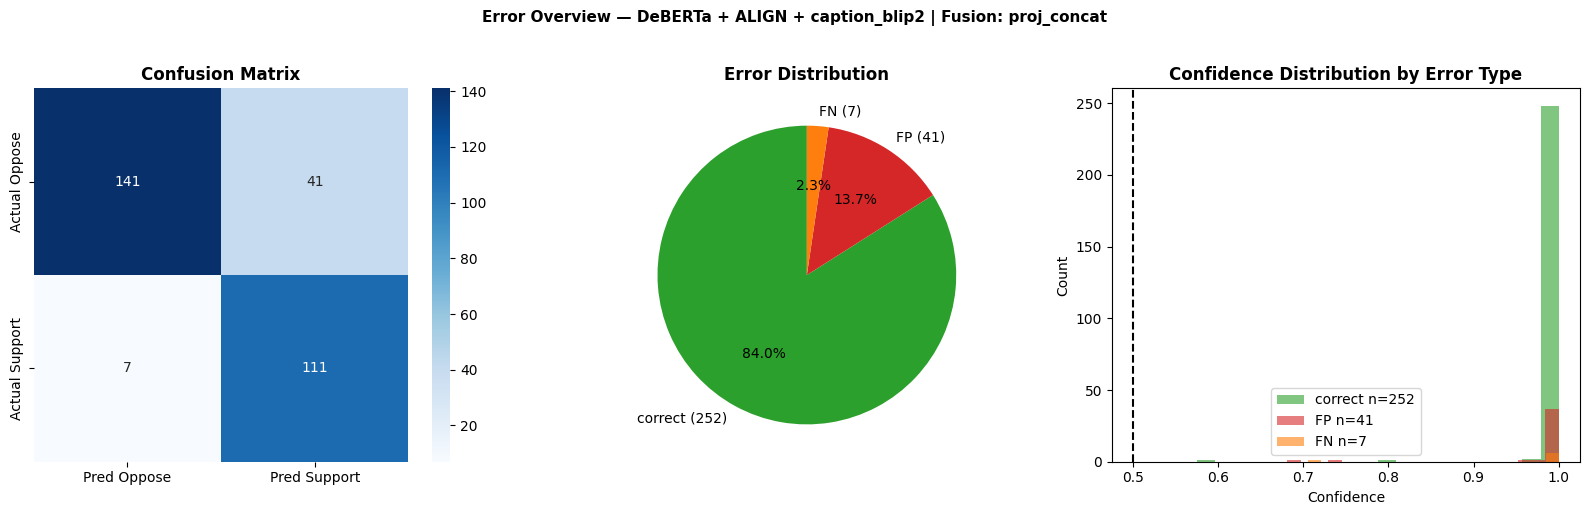


Confidence stats by error type:
              mean  median     min     max
error_type                                
FN          0.9566  0.9995  0.7059  0.9998
FP          0.9840  0.9999  0.6815  1.0000
correct     0.9968  0.9999  0.5746  1.0000


In [16]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Confusion matrix heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Pred Oppose','Pred Support'],
            yticklabels=['Actual Oppose','Actual Support'])
axes[0].set_title('Confusion Matrix', fontweight='bold')

# Error type pie
counts = df_pred['error_type'].value_counts()
axes[1].pie(counts.values, labels=[f"{k} ({v})" for k,v in counts.items()],
            colors=['#2ca02c','#d62728','#ff7f0e'], autopct='%1.1f%%', startangle=90)
axes[1].set_title('Error Distribution', fontweight='bold')

# Confidence by error type
for etype, color in [('correct','#2ca02c'),('FP','#d62728'),('FN','#ff7f0e')]:
    data = df_pred[df_pred['error_type']==etype]['confidence']
    if len(data) > 0:
        axes[2].hist(data, bins=20, alpha=0.6, label=f"{etype} n={len(data)}", color=color)
axes[2].axvline(0.5, color='black', linestyle='--', linewidth=1.5)
axes[2].set_xlabel('Confidence'); axes[2].set_ylabel('Count')
axes[2].set_title('Confidence Distribution by Error Type', fontweight='bold')
axes[2].legend()

plt.suptitle(f'Error Overview — {MODEL_DESC}', fontsize=11, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, f'{ckpt_name}_01_overview.png'), dpi=150, bbox_inches='tight')
plt.show()

print("\nConfidence stats by error type:")
print(df_pred.groupby('error_type')['confidence'].agg(['mean','median','min','max']).round(4))

### FP Analysis: Oppose predicted as Support

In [17]:
print(f"\nFALSE POSITIVES: {len(df_fp)} cases")
print("Real: Oppose were Predicted: Support\n")

# Confidence breakdown
print("P(support) confidence bins:")
for lo, hi in [(0.5,0.6),(0.6,0.7),(0.7,0.8),(0.8,0.9),(0.9,1.01)]:
    n   = ((df_fp['prob_support']>=lo) & (df_fp['prob_support']<hi)).sum()
    bar = '█' * int(n)
    print(f"  [{lo:.1f}–{hi:.1f}): {n:3d}  {bar}")

# Text length
print(f"\nText length: mean={df_fp['text_length'].mean():.1f} | "
      f"vs correct mean={df_correct['text_length'].mean():.1f}")
if USE_CAPTION:
    print(f"Caption length: mean={df_fp['caption_length'].mean():.1f} | "
          f"vs correct mean={df_correct['caption_length'].mean():.1f}")

# Most confident FP
print("\nTop 5 most confident FP:")
top_fp = df_fp.nlargest(5, 'prob_support')[['tweet_text','prob_support']]
top_fp['tweet_text'] = top_fp['tweet_text'].str[:80]
print(top_fp.to_string(index=False))


FALSE POSITIVES: 41 cases
Real: Oppose were Predicted: Support

P(support) confidence bins:
  [0.5–0.6):   0  
  [0.6–0.7):   1  █
  [0.7–0.8):   1  █
  [0.8–0.9):   0  
  [0.9–1.0):  39  ███████████████████████████████████████

Text length: mean=35.2 | vs correct mean=34.4
Caption length: mean=8.5 | vs correct mean=9.2

Top 5 most confident FP:
                                                                      tweet_text  prob_support
Women are five times more likely to be killed by their abuser if there is a gun       0.999974
WA state will have the nation's 1st Office of Firearm Safety and Violence Preven      0.999974
We know people are scared and stressed during this uncertain time, but stockpili      0.999974
#SanDiego @MomsDemand down at #LaJolla Shores Park to support a stop along the r      0.999973
With schools closed, opportunities for kids to be unsupervised increase, raising      0.999972


### Visual Examples: FP (Most Confident)

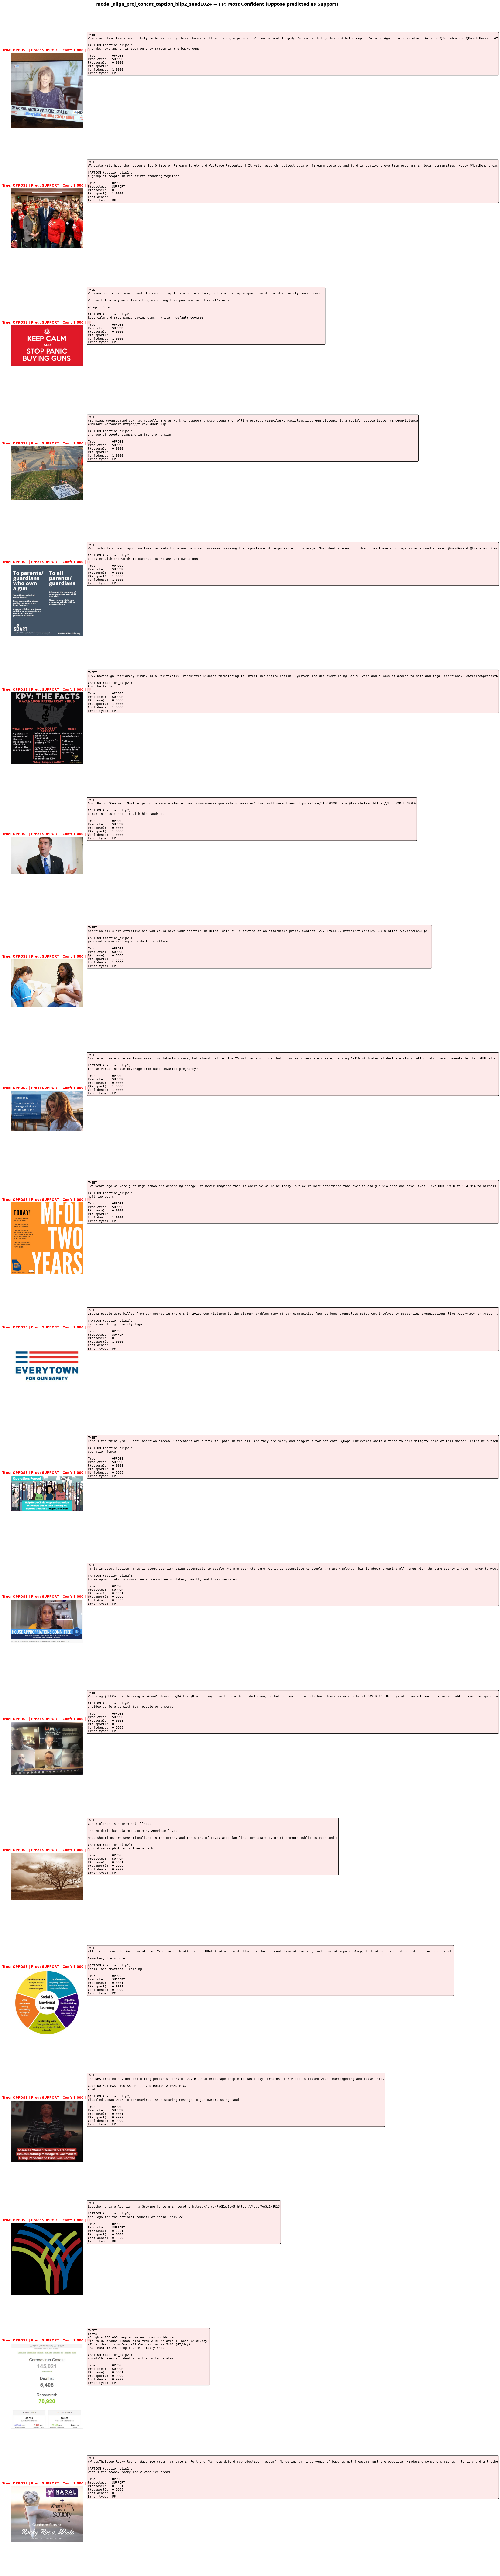

In [22]:
def show_examples(df_subset, title, max_examples=10, sort_by='confidence', ascending=False):
    df_show = df_subset.sort_values(sort_by, ascending=ascending).head(max_examples)
    n = len(df_show)
    if n == 0:
        print(f"No examples to show for: {title}")
        return

    fig = plt.figure(figsize=(18, 5.5 * n))
    fig.suptitle(title, fontsize=13, fontweight='bold', y=1.005)

    for i, (_, row) in enumerate(df_show.iterrows()):
        # Image
        ax_img = fig.add_subplot(n, 2, 2*i + 1)
        img_path = os.path.join(IMG_PATH, str(row['tweet_id']) + ".jpg")
        try:
            ax_img.imshow(Image.open(img_path).convert('RGB'))
        except:
            ax_img.imshow(np.ones((224, 224, 3)))
            ax_img.text(0.5, 0.5, '[Image not found]', ha='center', va='center',
                        transform=ax_img.transAxes, fontsize=10)
        ax_img.axis('off')
        color = 'red' if row['error_type'] != 'correct' else 'green'
        ax_img.set_title(
            f"True: {row['stance'].upper()} | Pred: {row['pred_stance'].upper()} | "
            f"Conf: {row['confidence']:.3f} | {row['error_type'].upper()}",
            fontsize=10, color=color, fontweight='bold')

        # Info panel
        ax_txt = fig.add_subplot(n, 2, 2*i + 2)
        ax_txt.axis('off')
        info  = f"TWEET:\n{str(row['tweet_text'])[:220]}\n\n"
        if USE_CAPTION:
            info += f"CAPTION ({CAPTION_TYPE}):\n{str(row[CAPTION_TYPE])[:160]}\n\n"
        info += f"True:        {row['stance'].upper()}\n"
        info += f"Predicted:   {row['pred_stance'].upper()}\n"
        info += f"P(oppose):   {row['prob_oppose']:.4f}\n"
        info += f"P(support):  {row['prob_support']:.4f}\n"
        info += f"Confidence:  {row['confidence']:.4f}\n"
        info += f"Error type:  {row['error_type']}"
        bg = '#fde8e8' if row['error_type']=='FP' else '#fff3cd' if row['error_type']=='FN' else '#d4f5d4'
        ax_txt.text(0.02, 0.98, info, transform=ax_txt.transAxes,
                    fontsize=9.5, verticalalignment='top', fontfamily='monospace',
                    bbox=dict(boxstyle='round', facecolor=bg, alpha=0.9))

    plt.tight_layout()
    fname = re.sub(r'[^\w]+', '_', title.lower()).strip('_') + ".png"
    plt.savefig(os.path.join(OUTPUT_DIR, fname), dpi=120, bbox_inches='tight')
    plt.show()


show_examples(
    df_fp,
    title=f"{ckpt_name} — FP: Most Confident (Oppose predicted as Support)",
    max_examples=min(20, len(df_fp)),
    sort_by='prob_support',
    ascending=False
)

### Visual Examples: FN (All Cases)

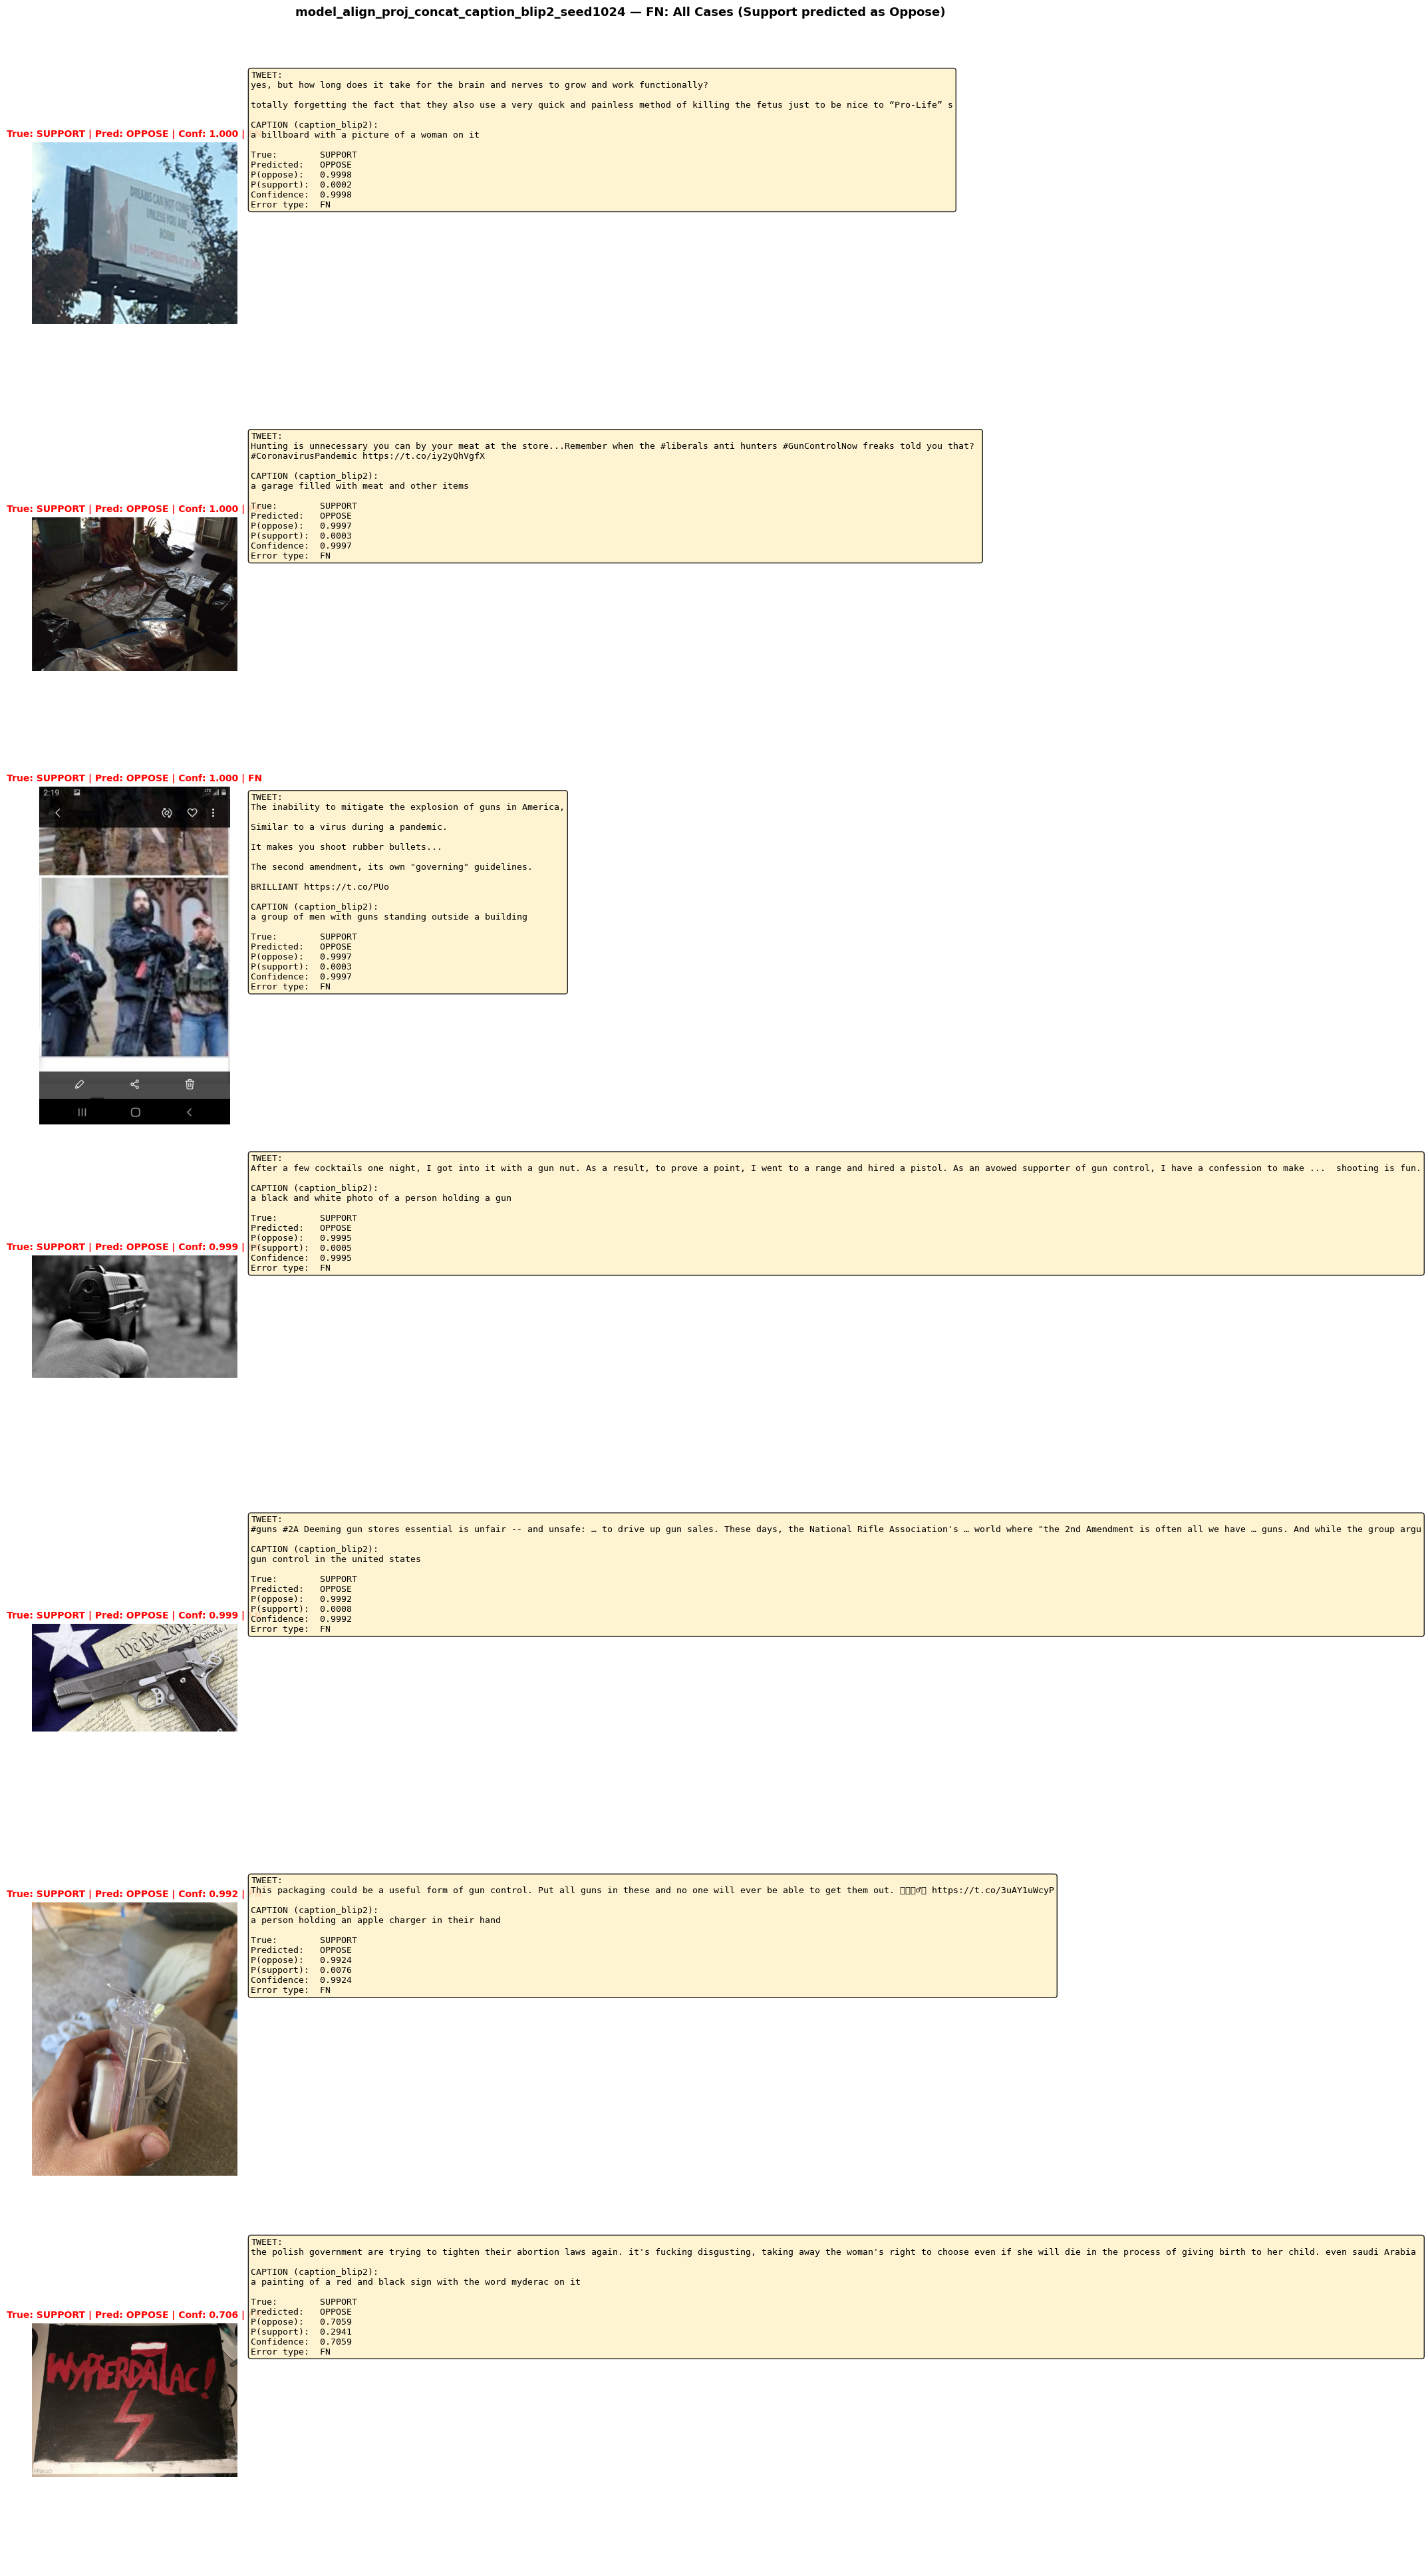

In [19]:
show_examples(
    df_fn,
    title=f"{ckpt_name} — FN: All Cases (Support predicted as Oppose)",
    max_examples=len(df_fn),
    sort_by='prob_oppose',
    ascending=False
)

## Borderline Cases (Most Uncertain)

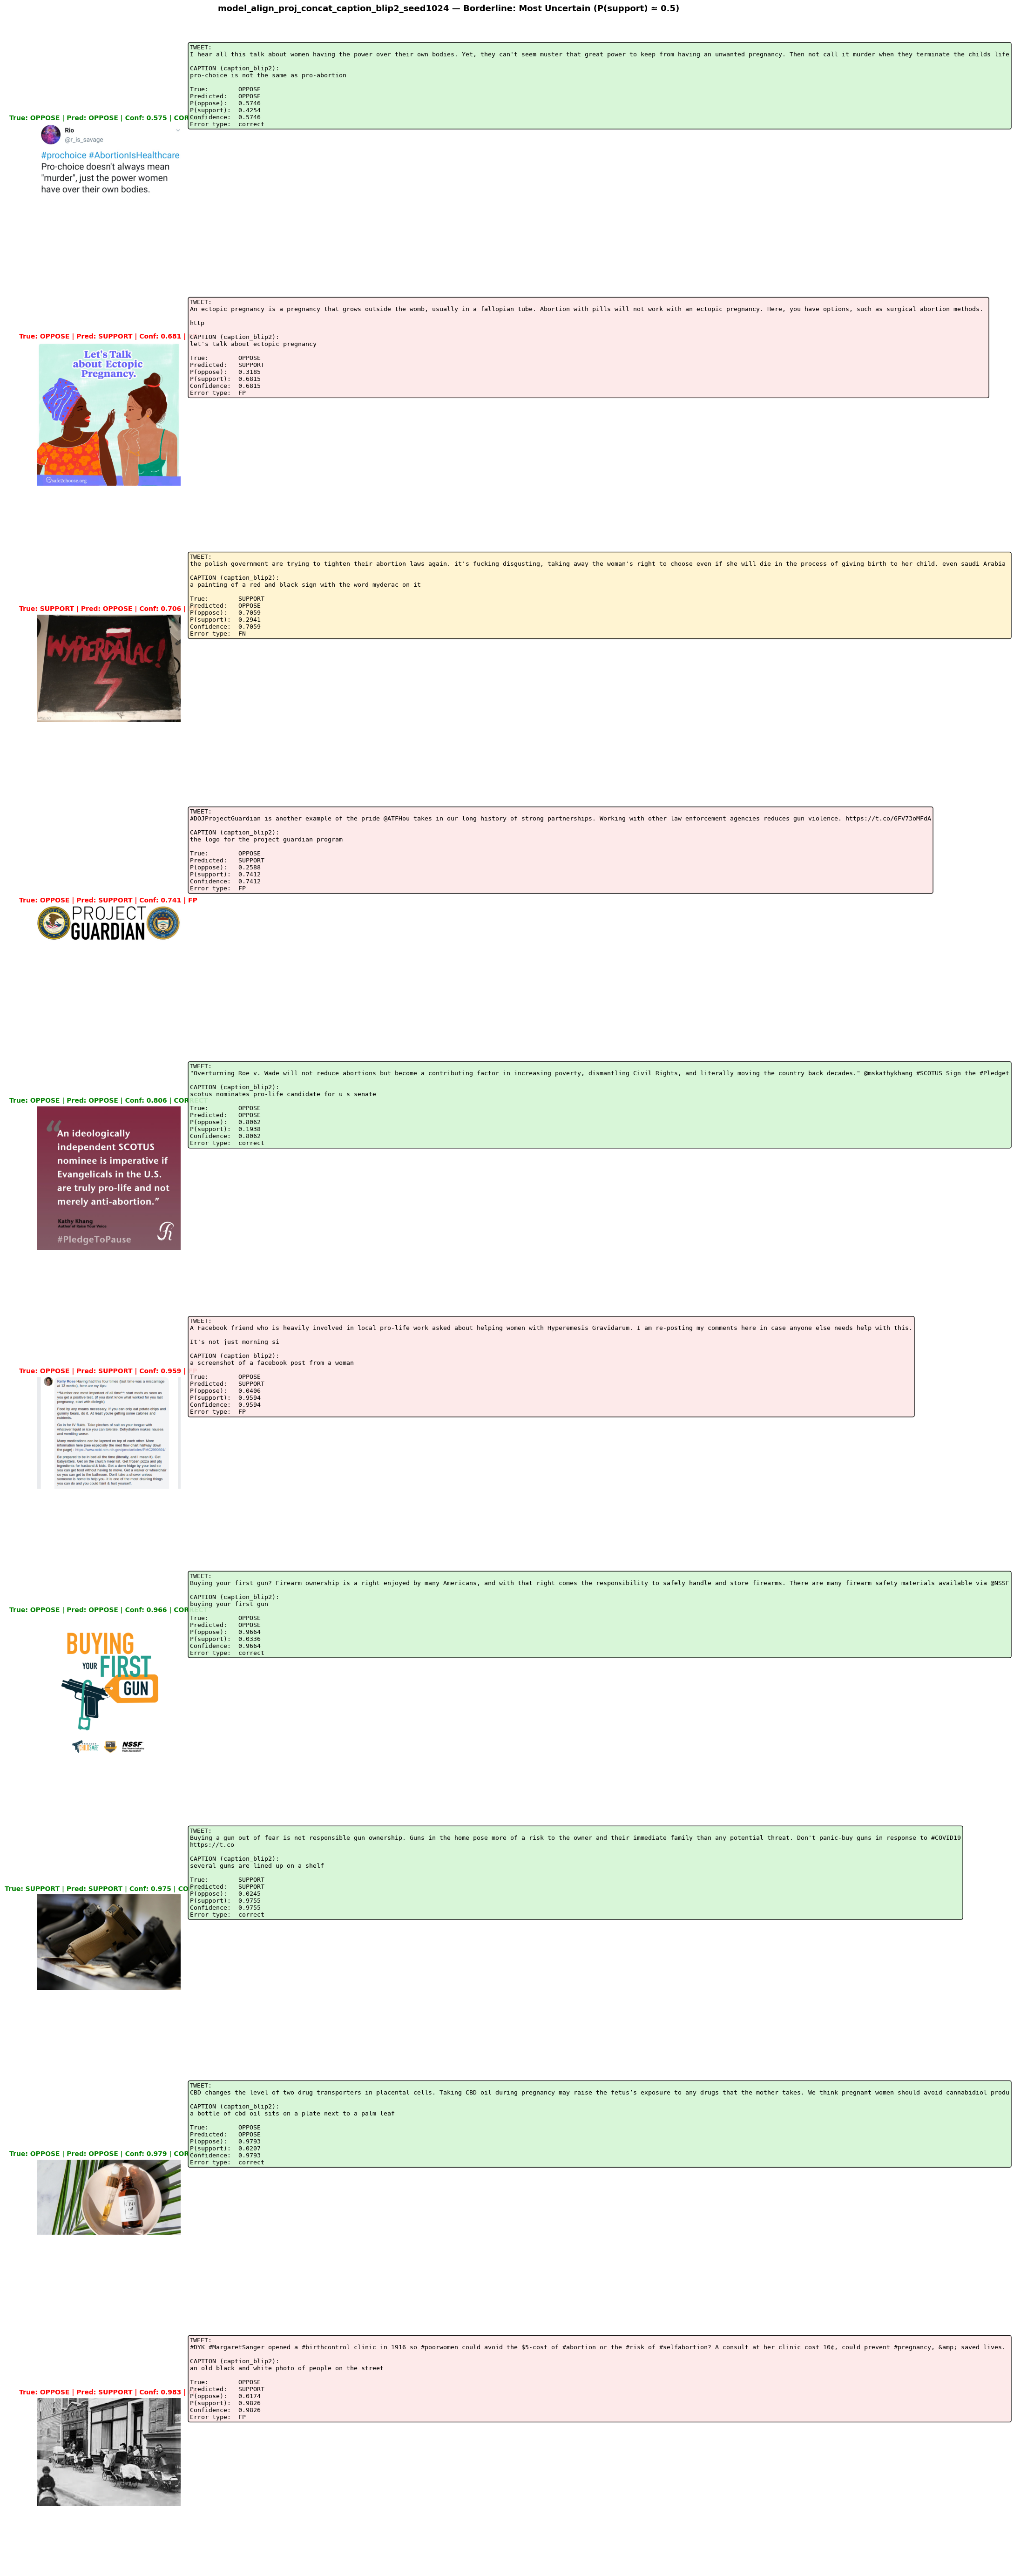

In [20]:
show_examples(
    df_pred,
    title=f"{ckpt_name} — Borderline: Most Uncertain (P(support) ≈ 0.5)",
    max_examples=10,
    sort_by='uncertainty',
    ascending=True
)

### Caption Comparison (BLIP2 vs GIT) on Errors

In [21]:
if USE_CAPTION and 'caption_git' in df_pred.columns and 'caption_blip2' in df_pred.columns:
    print("\nCaption comparison for FP cases:")
    print("(Showing up to 8 FP examples — BLIP2 vs GIT captions)\n")
    show_cols = ['tweet_text','caption_blip2','caption_git','prob_support']
    disp = df_fp.nlargest(8, 'prob_support')[show_cols].copy()
    disp['tweet_text']    = disp['tweet_text'].str[:60]
    disp['caption_blip2'] = disp['caption_blip2'].str[:70]
    disp['caption_git']   = disp['caption_git'].str[:70]
    print(disp.to_string(index=False))

    # Caption length comparison
    print("\nCaption length by error type:")
    for cap_col in ['caption_blip2', 'caption_git']:
        df_pred[f'len_{cap_col}'] = df_pred[cap_col].str.split().str.len()
        print(f"\n  {cap_col}:")
        print(df_pred.groupby('error_type')[f'len_{cap_col}'].agg(['mean','median']).round(2))
else:
    print("Caption comparison skipped.")


Caption comparison for FP cases:
(Showing up to 8 FP examples — BLIP2 vs GIT captions)

                                                  tweet_text                                                  caption_blip2                                                            caption_git  prob_support
Women are five times more likely to be killed by their abuse   the nbc news anchor is seen on a tv screen in the background                         a television screen showing a woman on a desk.      0.999974
WA state will have the nation's 1st Office of Firearm Safety              a group of people in red shirts standing together                                     [ unused0 ] with a group of people      0.999974
We know people are scared and stressed during this uncertain keep calm and stop panic buying guns - white - default 600x800 keep calm and stop panic buying guns poster featuring the digital art       0.999974
#SanDiego @MomsDemand down at #LaJolla Shores Park to suppor               